### aim: calculate co2 flux from medusa files

### date: 

- the yearly files come from makeYearlyMEDUSAsubsetfiles

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
test = False

### medusa scenario dictionary

In [5]:
scendict = {
    # Baynes Sound
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

#### plot area

In [6]:
w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
w
tar = (w['area'].values)
pco2 = w['CO2FLUX'][0,:,:].values
np.shape(pco2)
tar[np.isnan(pco2)] = np.nan
# nav_lat = (w['nav_lat'])
# print(nav_lat[113,:].values)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


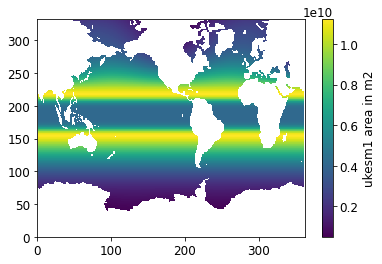

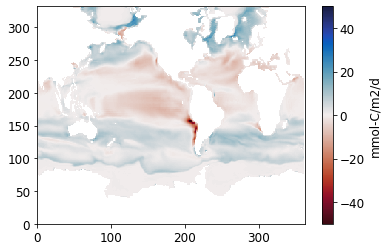

In [7]:
plt.figure()
w2 = plt.pcolormesh(w['area'])
plt.colorbar(w2, label = 'ukesm1 area in m2')

plt.figure()
w2 = plt.pcolormesh(w['CO2FLUX'][0,:,:], vmin = -50, vmax = 50, cmap = 'cmo.balance_r')
plt.colorbar(w2, label = w['CO2FLUX'].units)

In [8]:

def yr_month_cmeans_csums(mon, ds, verbose = False):
    
    OCN_PCO2 = ds['OCN_PCO2']
    CO2FLUX = ds['CO2FLUX']
    ma = np.ma.MaskedArray(OCN_PCO2[mon-1,:,:], mask=np.isnan(OCN_PCO2[mon-1,:,:]))
    tarmask = np.ma.MaskedArray(tar, mask=np.isnan(tar))
    OCN_PCO2_mn = np.ma.average(ma, weights=tarmask)

    ma = np.ma.MaskedArray(OCN_PCO2[mon-1,0:113,:], mask=np.isnan(OCN_PCO2[mon-1,0:113,:]))
    tarmask = np.ma.MaskedArray(tar[0:113,:], mask=np.isnan(tar[0:113,:]))
    OCN_PCO2_SO_mn = np.ma.average(ma, weights=tarmask)
    
    ma = np.ma.MaskedArray(CO2FLUX[mon-1,:,:], mask=np.isnan(CO2FLUX[mon-1,:,:]))
    tarmask = np.ma.MaskedArray(tar, mask=np.isnan(tar))
    CO2FLUX_mn = np.nansum(ma*tarmask)

    ma = np.ma.MaskedArray(CO2FLUX[mon-1,0:113,:], mask=np.isnan(CO2FLUX[mon-1,0:113,:]))
    tarmask = np.ma.MaskedArray(tar[0:113,:], mask=np.isnan(tar[0:113,:]))
    CO2FLUX_SO_mn = np.nansum(ma*tarmask)

    
    if verbose:
        print(OCN_PCO2_mn)
        print(OCN_PCO2_SO_mn)
        print(CO2FLUX_mn)
        print(CO2FLUX_SO_mn)
        
    return OCN_PCO2_mn, OCN_PCO2_SO_mn, CO2FLUX_mn, CO2FLUX_SO_mn

if test:
    ds = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa_be682_1y_2015_diad-T-subset.nc')
    yr_month_cmeans_csums(1, ds, verbose = True)
    yr_month_cmeans_csums(6, ds, verbose = True)
    
    OCN_PCO2_mn, OCN_PCO2_SO_mn, CO2FLUX_mn, CO2FLUX_SO_mn = yr_month_cmeans_csums(6, ds, verbose = True)

In [9]:
if test:
    mean_OCN_PCO2 = np.zeros([150,12])
    mean_OCN_PCO2_SO = np.zeros([150,12])
    mean_CO2FLUX = np.zeros([150,12])
    mean_CO2FLUX_SO = np.zeros([150,12])

    # yrs = np.arange(1950,2100,1)
    # mos = np.arange(1,13,1)

    # define data with variable attributes
    data_vars = {'mean_OCN_PCO2':(['year', 'month'], mean_OCN_PCO2,
                             {'units': 'µatm',
                              'long_name':'ocean pco2'}),
                 'mean_OCN_PCO2_SO':(['year', 'month'], mean_OCN_PCO2_SO,
                             {'units': 'µatm',
                              'long_name':'ocean pco2, south of -50'}),
                 'mean_CO2FLUX':(['year', 'month'], mean_CO2FLUX,
                             {'units': 'mmol C /day',
                              'long_name':'co2 flux'}),
                 'mean_CO2FLUX_SO':(['year', 'month'], mean_CO2FLUX_SO,
                             {'units': 'mmol C /day',
                              'long_name':'co2 flux'}),
                }

    # define coordinates
    coords = {'year': (['year'], np.arange(1950,2100,1)),\
             'month': (['month'], np.arange(1,13,1))}

    # define global attributes
    attrs = {'made in':'MEDUSA/MedusaCflxPco2.ipynb',
            }

    # create dataset
    ds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

    fn = f'./examplenetcdf.nc'
    ds.to_netcdf(fn)

In [10]:
if test:
    scens = ['1A','1B','2A','2B','3A','3B']


    tscen = scens[5]
    print(tscen)
    y = 1991
    if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
        print('yes')
        tstr = scendict['1A']['hist_str']
    elif y<2015:
        tstr = scendict[tscen]['hist_str']

    else:
        tstr = scendict[tscen]['fut_str']

    print(tstr)

## cell for calculating means and averages

In [11]:
extract = True

if extract:
    scens = ['1A','1B','2A','2B','3A','3B']

    for s in range(0,6):
        tscen = scens[s]
        fnam = f'./EXTRACT/medusa_{tscen}_CFLX_PCO2_1950-2100.nc'

        mean_OCN_PCO2 = np.zeros([150,12])
        mean_OCN_PCO2_SO = np.zeros([150,12])
        mean_CO2FLUX = np.zeros([150,12])
        mean_CO2FLUX_SO = np.zeros([150,12])


        for y in range(1950,2100):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa*{tstr}*{y}_diad-T*.nc')
                ds = xr.open_dataset(td[0])
                for m in range(1,13):
                    OCN_PCO2_mn, OCN_PCO2_SO_mn, CO2FLUX_mn, CO2FLUX_SO_mn = \
                    yr_month_cmeans_csums(m, ds, verbose = False)
                    mean_OCN_PCO2[y-1950,m-1] = OCN_PCO2_mn
                    mean_OCN_PCO2_SO[y-1950,m-1] = OCN_PCO2_SO_mn
                    mean_CO2FLUX[y-1950,m-1] = CO2FLUX_mn
                    mean_CO2FLUX_SO[y-1950,m-1] = CO2FLUX_SO_mn
                print(f'GOOD {tscen},{tstr}, {y}, {OCN_PCO2_mn}')
            except:
                print(f'FAIL {tscen},{tstr}, {y}')



        data_vars = {'mean_OCN_PCO2':(['year', 'month'], mean_OCN_PCO2,
                                 {'units': 'µatm',
                                  'long_name':'ocean pco2'}),
                     'mean_OCN_PCO2_SO':(['year', 'month'], mean_OCN_PCO2_SO,
                                 {'units': 'µatm',
                                  'long_name':'ocean pco2, south of -50'}),
                     'mean_CO2FLUX':(['year', 'month'], mean_CO2FLUX,
                                 {'units': 'mmol C /day',
                                  'long_name':'co2 flux'}),
                     'mean_CO2FLUX_SO':(['year', 'month'], mean_CO2FLUX_SO,
                                 {'units': 'mmol C /day',
                                  'long_name':'co2 flux'}),
                    }

        # define coordinates
        coords = {'year': (['year'], np.arange(1950,2100,1)),\
                 'month': (['month'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'MEDUSA/MedusaCflxPco2.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        #fn = f'./examplenetcdf.nc'
        ds.to_netcdf(fnam)

FAIL 1A,bc370, 1950
FAIL 1A,bc370, 1951
FAIL 1A,bc370, 1952
FAIL 1A,bc370, 1953
FAIL 1A,bc370, 1954
FAIL 1A,bc370, 1955
FAIL 1A,bc370, 1956
FAIL 1A,bc370, 1957
FAIL 1A,bc370, 1958
FAIL 1A,bc370, 1959
FAIL 1A,bc370, 1960
FAIL 1A,bc370, 1961
FAIL 1A,bc370, 1962
FAIL 1A,bc370, 1963
FAIL 1A,bc370, 1964
FAIL 1A,bc370, 1965
FAIL 1A,bc370, 1966
FAIL 1A,bc370, 1967
FAIL 1A,bc370, 1968
FAIL 1A,bc370, 1969
FAIL 1A,bc370, 1970
FAIL 1A,bc370, 1971
FAIL 1A,bc370, 1972
FAIL 1A,bc370, 1973
FAIL 1A,bc370, 1974
FAIL 1A,bc370, 1975
FAIL 1A,bc370, 1976
FAIL 1A,bc370, 1977
FAIL 1A,bc370, 1978
FAIL 1A,bc370, 1979
FAIL 1A,bc370, 1980
FAIL 1A,bc370, 1981
FAIL 1A,bc370, 1982
FAIL 1A,bc370, 1983
FAIL 1A,bc370, 1984
FAIL 1A,bc370, 1985
FAIL 1A,bc370, 1986
FAIL 1A,bc370, 1987
FAIL 1A,bc370, 1988
FAIL 1A,bc370, 1989
FAIL 1A,bc370, 1990
FAIL 1A,bc370, 1991
FAIL 1A,bc370, 1992
FAIL 1A,bc370, 1993
FAIL 1A,bc370, 1994
FAIL 1A,bc370, 1995
FAIL 1A,bc370, 1996
FAIL 1A,bc370, 1997
FAIL 1A,bc370, 1998
FAIL 1A,bc370, 1999


In [12]:
mmolC_to_PgC = 1e-18*12

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


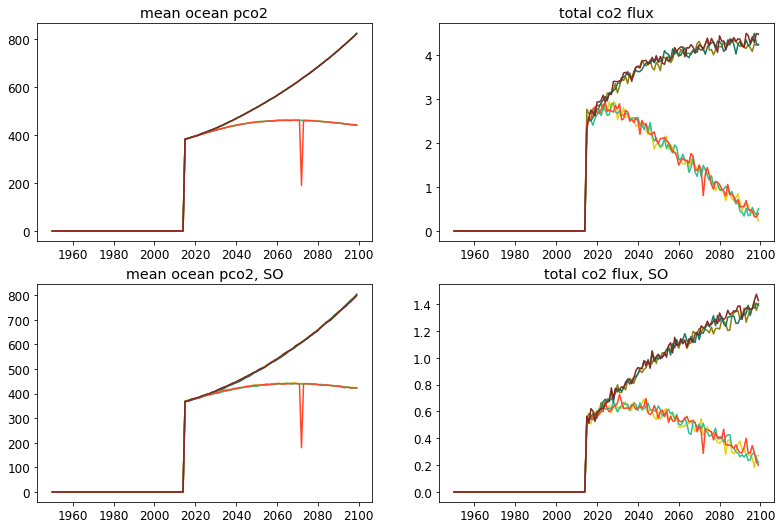

In [13]:
dim = np.array([31,28,31,30,31,30,31,31,30,31,30,31])

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for s in range(0,6):
    tcol = scendict[scens[s]]['color']
    scennam = scendict[scens[s]]['name']
    tnam = f'./EXTRACT/medusa_{scens[s]}_CFLX_PCO2_1950-2100.nc'


    w = xr.open_dataset(tnam)
    #print(w)
    #print(np.shape(w['mean_OCN_PCO2'].values))
    t = w['mean_OCN_PCO2'].values
    t2 = w['mean_CO2FLUX'].values


    mean_OCN_PCO2_ts = np.zeros([150])
    mean_CO2FLUX_ts = np.zeros([150])
    mean_OCN_PCO2_SO_ts = np.zeros([150])
    mean_CO2FLUX_SO_ts = np.zeros([150])
    for i in range(0,150):
        mean_OCN_PCO2_ts[i] = np.ma.average(w['mean_OCN_PCO2'][i,:], weights=dim)
        mean_OCN_PCO2_SO_ts[i] = np.ma.average(w['mean_OCN_PCO2_SO'][i,:], weights=dim)
        mean_CO2FLUX_ts[i] = np.nansum(w['mean_CO2FLUX'][i,:] * dim)
        mean_CO2FLUX_SO_ts[i] = np.nansum(w['mean_CO2FLUX_SO'][i,:] * dim)

    axs[0].plot(np.arange(1950,2100), mean_OCN_PCO2_ts, color = tcol, label = scennam)
    axs[0].set_title('mean ocean pco2')
    axs[1].plot(np.arange(1950,2100), mean_CO2FLUX_ts * mmolC_to_PgC, color = tcol )
    axs[1].set_title('total co2 flux')
    axs[2].plot(np.arange(1950,2100), mean_OCN_PCO2_SO_ts, color = tcol )
    axs[2].set_title('mean ocean pco2, SO')
    axs[3].plot(np.arange(1950,2100), mean_CO2FLUX_SO_ts * mmolC_to_PgC, color = tcol )
    axs[3].set_title('total co2 flux, SO')

In [14]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa_cj881_1y_2015_diad-T-subset.nc')
print(w)

#need area

<xarray.Dataset>
Dimensions:       (deptht: 75, nav_lat: 332, nav_lon: 362, time_counter: 12)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2015-01-31 ... 2015-12-31
  * nav_lat       (nav_lat) float32 -84.21071 -84.108955 ... 50.01094 50.01094
  * nav_lon       (nav_lon) float32 72.5 73.5 74.5 75.5 ... 70.5 71.5 72.5 73.5
  * deptht        (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
Data variables:
    OCN_PCO2      (time_counter, nav_lat, nav_lon) float64 ...
    CO2FLUX       (time_counter, nav_lat, nav_lon) float64 ...
Attributes:
    made in:  SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb
    desc:     yearly medusa files, saving only variables of interest


In [15]:
horse = False
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj200o'
    i = 0
    cj200o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            print(q[0])
            cj200o_co2flux[i,:,:] = tdat['CO2FLUX'][0,:,:]
            print(np.nansum(cj200o_co2flux[i,:,:]))
            i = i+1
    print(i)
    pickle.dump(cj200o_co2flux, open("medusa_cj200o_CO2FLUX_1990_2015.pkl", 'wb'))

# horse = True
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj198o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj198o'
    i = 0
    cj198o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            cj198o_co2flux[i,:,:] = tdat['CO2FLUX'][0,:,:]
            i = i+1
            print(i)
    print(i)
    pickle.dump(cj198o_co2flux, open("medusa_cj198o_CO2FLUX_1990_2015.pkl", 'wb'))

In [16]:
horse = False
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj200o'
    i = 0
    cj200o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            print(q[0])
            cj200o_co2flux[i,:,:] = tdat['OCN_PCO2'][0,:,:]
            print(np.nansum(cj200o_co2flux[i,:,:]))
            i = i+1
    print(i)
    pickle.dump(cj200o_co2flux, open("medusa_cj200o_OCN_PCO2_1990_2015.pkl", 'wb'))

# horse = True
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj198o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj198o'
    i = 0
    cj198o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            cj198o_co2flux[i,:,:] = tdat['OCN_PCO2'][0,:,:]
            i = i+1
            print(i)
    print(i)
    pickle.dump(cj198o_co2flux, open("medusa_cj198o_OCN_PCO2_1990_2015.pkl", 'wb'))

In [17]:
#prasime_veci
dim = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
mos = np.arange(1,13,1)
yrs = np.arange(1990,2015,1)
print(np.shape(yrs))

yrsrep = np.zeros(300)
mosrep = np.zeros(300)
dimrep = np.zeros(300)

for i in range(0,25):
    yrsrep[i*12:i*12+12] = 1990+i
    mosrep[i*12:i*12+12] = mos
    dimrep[i*12:i*12+12] = dim
    
# print(mosrep)


(25,)


In [18]:
cj200o_co2flux = pickle.load(open('medusa_cj200o_CO2FLUX_1990_2015.pkl', 'rb'))
cj198o_co2flux = pickle.load(open('medusa_cj198o_CO2FLUX_1990_2015.pkl', 'rb'))
cj200o_ocn_pco2 = pickle.load(open('medusa_cj200o_OCN_PCO2_1990_2015.pkl', 'rb'))
cj198o_ocn_pco2 = pickle.load(open('medusa_cj198o_OCN_PCO2_1990_2015.pkl', 'rb'))
print(np.shape(cj198o_ocn_pco2))

(300, 332, 362)


In [19]:
yrslog = np.arange(1990,2015,1/12)
print(np.shape(yrslog))

(300,)


In [20]:
w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
tar = (w['area'].values)
nav_lat = (w['nav_lat'])
print(w.area)
print(w.CO2FLUX)
## 113 is the nav lat boundary



<xarray.DataArray 'area' (y: 332, x: 362)>
array([[1.600000e+01, 1.600000e+01, 1.600000e+01, ..., 1.600000e+01,
        1.600000e+01, 1.600000e+01],
       [1.600000e+01, 1.600000e+01, 1.600000e+01, ..., 1.600000e+01,
        1.600000e+01, 1.600000e+01],
       [1.600000e+01, 1.600000e+01, 1.600000e+01, ..., 1.600000e+01,
        1.600000e+01, 1.600000e+01],
       ...,
       [4.967845e+07, 4.967845e+07, 1.681953e+08, ..., 1.681953e+08,
        4.967845e+07, 4.967845e+07],
       [3.180358e+07, 3.180358e+07, 1.550036e+08, ..., 1.550036e+08,
        3.180358e+07, 3.180358e+07],
       [3.180358e+07, 3.180358e+07, 1.550036e+08, ..., 1.550036e+08,
        3.180358e+07, 3.180358e+07]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    standard_name:  cell_area
    units:          m2
<xarray.DataArray 'CO2FLUX' (time_counter: 1, y: 332, x: 362)>
[120184 values with dtype=float32]
Dimensions without coordinates: time_counter, y, x
Attributes:
    long_name:           Air-s

In [21]:
   BAC                   (time_counter, deptht, y, x) float32 ...
    PRO                   (time_counter, deptht, y, x) float32 ...
    PTE                   (time_counter, deptht, y, x) float32 ...
    MES                   (time_counter, deptht, y, x) float32 ...
    GEL                   (time_counter, deptht, y, x) float32 ...
    MAC                   (time_counter, deptht, y, x) float32 ...
    DIA                   (time_counter, deptht, y, x) float32 ...
    MIX                   (time_counter, deptht, y, x) float32 ...
    COC                   (time_counter, deptht, y, x) float32 ...
    PIC                   (time_counter, deptht, y, x) float32 ...
    PHA                   (time_counter, deptht, y, x) float32 ...
    FIX                   (time_counter, deptht, y, x) float32 ...

SyntaxError: invalid syntax (2787139282.py, line 1)

In [ ]:
names = ['BAC','PRO','PTE','MES','GEL','MAC','DIA','MIX','COC','PIC','PHA','FIX']
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_RW_3G76/ORCA2_1m_20210101_20211231_ptrc_T.nc')
for i in range(0, len(names)):
    print(w[names[i]])

In [ ]:
siy = 60*60*24*365
pg_in_mol = 12 * 1e-15
pg_in_mmol = 12 * 1e-18
diy = 365


Acj198o_co2flux_so = np.zeros([300])
Acj198o_co2flux = np.zeros([300])
Acj200o_co2flux_so = np.zeros([300])
Acj200o_co2flux = np.zeros([300])

for i in range(0,300):
    Acj198o_co2flux_so[i] = np.nansum(cj198o_co2flux[i,0:113,:] * tar[0:113,:])* pg_in_mmol * dimrep[i]
    Acj198o_co2flux[i] = np.nansum(cj198o_co2flux[i,:,:] * tar[:,:])* pg_in_mmol * dimrep[i]
    Acj200o_co2flux_so[i] = np.nansum(cj200o_co2flux[i,0:113,:] * tar[0:113,:])* pg_in_mmol * dimrep[i]
    Acj200o_co2flux[i] = np.nansum(cj200o_co2flux[i,:,:] * tar[:,:]) * pg_in_mmol * dimrep[i]

## per month

In [ ]:

fact = 2
fig, axs = plt.subplots(2,1, figsize=(4.8*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrslog,Acj200o_co2flux, label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(yrslog,Acj198o_co2flux, label = 'no ozone hole')
axs[1].plot(yrslog,Acj200o_co2flux_so, label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(yrslog,Acj198o_co2flux_so, label = 'no ozone hole')

axs[0].legend()

for i in range(0,2):
    axs[i].grid()
    axs[i].set_xlim([1990,2015])
plt.suptitle('monthly carbon uptake (pG CO2)) in UKESM1-MEDUSA \n 2 ozone scenarios 1990-2015 \n top plot global, bottom SO')

In [ ]:
Ycj198o_co2flux_so = np.zeros([25])
Ycj198o_co2flux = np.zeros([25])
Ycj200o_co2flux_so = np.zeros([25])
Ycj200o_co2flux = np.zeros([25])

for y in range(1990,2015):
    Ycj200o_co2flux[y-1990] = np.nansum(Acj200o_co2flux[yrsrep ==y])
    Ycj200o_co2flux_so[y-1990] = np.nansum(Acj200o_co2flux_so[yrsrep ==y])
    Ycj198o_co2flux[y-1990] = np.nansum(Acj198o_co2flux[yrsrep ==y])
    Ycj198o_co2flux_so[y-1990] = np.nansum(Acj198o_co2flux_so[yrsrep ==y])    
# plt.plot(Ycj200o_co2flux)

In [ ]:

fact = 2
fig, axs = plt.subplots(2,1, figsize=(4.8*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1990,2015,1),Ycj200o_co2flux, color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(np.arange(1990,2015,1),Ycj198o_co2flux, color = 'k', label = 'no ozone hole')
axs[1].plot(np.arange(1990,2015,1),Ycj200o_co2flux_so, color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(np.arange(1990,2015,1),Ycj198o_co2flux_so, color = 'k', label = 'no ozone hole')
axs[0].plot(2002.5,np.nanmean(Ycj200o_co2flux), marker = 'o', color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(2002.5,np.nanmean(Ycj198o_co2flux), marker = 'o', color = 'k', label = 'no ozone hole')
axs[1].plot(2002.5,np.nanmean(Ycj200o_co2flux_so), marker = 'o', color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(2002.5,np.nanmean(Ycj198o_co2flux_so), marker = 'o', color = 'k', label = 'no ozone hole')

axs[0].legend()

for i in range(0,2):
    axs[i].grid()
    axs[i].set_xlim([1990,2015])
plt.suptitle('yearly carbon uptake (pG CO2)) in UKESM1-MEDUSA \n 2 ozone scenarios 1990-2015 \n (bottom plot is SO)')